# Bone marrow tissue segmentation

Teophile Lemay, 2022-06

this notebook has my experimentation for bone marrow tissue segmentation using images from the lab of dr Huber Tsui
working with Katelyn wang on the segmentation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import skimage.io as io
from skimage.filters.rank import entropy
from skimage.morphology import disk

# Entropy based method:
Works on "large image" to segment out desired tissue, removing bone and empty area

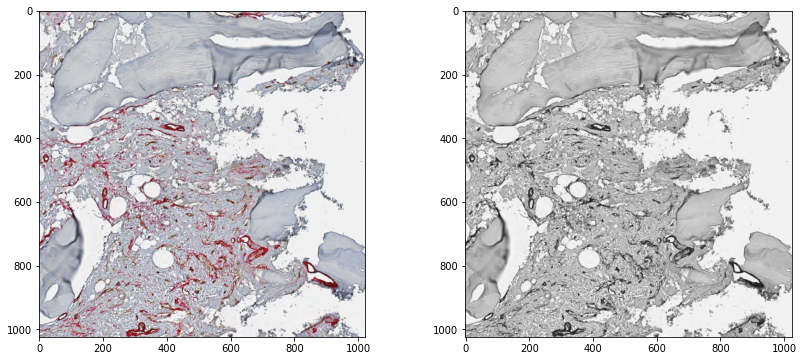

In [2]:
path = r'LARGE_IMAGE-T23-B13-7359_22528_10240_20.0X.tif'
im = io.imread(path)
gim = io.imread(path, as_gray=True)
# gim = cv.cvtColor(im[:, :, ::-1], cv.COLOR_BGR2GRAY)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(gim, 'gray')
plt.show()

C:\Users\teole\AppData\Local\Temp/ipykernel_13936/508932712.py:2: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  ent = entropy(gim, disk(5))


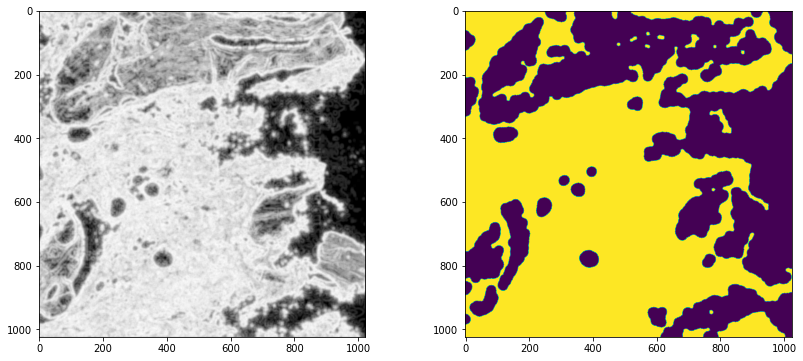

In [3]:
#entropy
ent = entropy(gim, disk(5))
threshold = 5 #threshold was decided by inspection of the entropy image.
#binary map
binmap = np.ones(ent.shape, dtype=np.uint8)
binmap[ent < threshold] = 0
#adjusting binary map
open = cv.morphologyEx(binmap, cv.MORPH_OPEN, disk(5))
closed = cv.morphologyEx(open, cv.MORPH_CLOSE, disk(15))

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.imshow(ent, 'gray')
plt.subplot(1, 2, 2)
plt.imshow(closed)
plt.show()


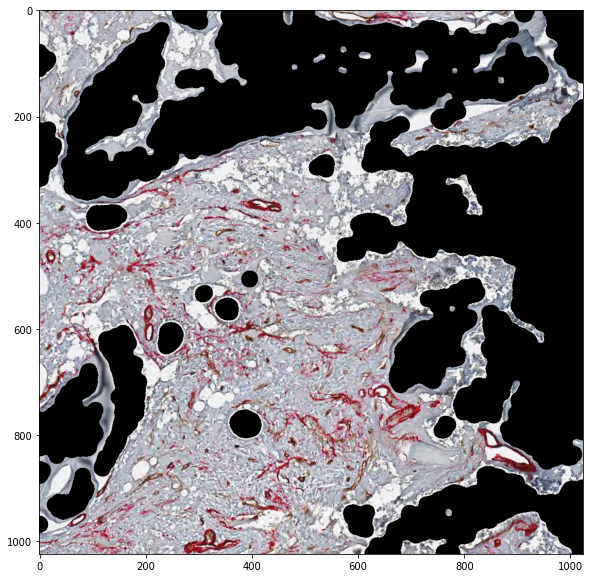

In [4]:
tissue = im * np.atleast_3d(closed)
plt.figure(figsize=(10,10))
plt.imshow(tissue)
plt.show()

# LBP comparisons
would probably work best for tile comparisons.

Pipeline:
- tile images
- provide reference tiles for Bone, Background, good desirable tissue.
- calculate lbp histogram for each (take means when have multiple reference samples per category)
- sort tiles according to lbp histogram matches w.r.t. reference histograms. 
    - For now use Kullback-Leibler divergence as per skimage example. 
    - (https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html)

Not perfect. Bone has much more distinctive texture than marrow. seems to miss some bones with finer "ridge" pattern.


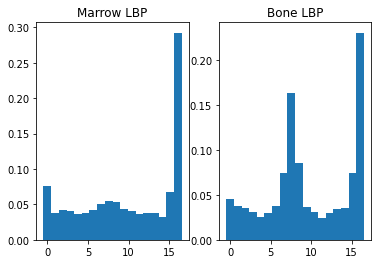

In [5]:
#"training" by making lbp histograms for comparison on exemplar tissue and bone areas.
from skimage.feature import local_binary_pattern as lbp

#changing radius values has small effect on final result.
radius = 2
npoints = radius * 8

tissuepaths = [r'images\T23-B13-7359_21900_11700_20.0X.tif', r'images\T23-B13-7359_21300_9900_20.0X.tif', r'images\T23-B13-7359_20700_8100_20.0X.tif']
bonepaths = [r'images\T23-B13-7359_22500_8700_20.0X.tif', r'images\T23-B13-7359_24300_11100_20.0X.tif', r'images\T23-B13-7359_23700_8700_20.0X.tif']

#currently no "background" tile for examples
marrows = []
for tissuepath in tissuepaths:
    tissue = io.imread(tissuepath, as_gray=True)
    lbpmarrow = lbp(tissue, npoints, radius, method='uniform').ravel()
    marrowhist, _medges = np.histogram(lbpmarrow, bins=int(lbpmarrow.max()+1), density=True)
    marrows.append(marrowhist)
marrowhist = np.mean(np.array(marrows), axis=0)

bones = []
for bonepath in bonepaths:
    bone = io.imread(bonepath, as_gray=True)
    lbpbone = lbp(bone, npoints, radius, method='uniform').ravel()
    bonehist, _bedges = np.histogram(lbpbone, bins=int(lbpbone.max()+1), density=True)
    bones.append(bonehist)
bonehist = np.mean(np.array(bones), axis=0)

compare = {'marrow':marrowhist, 'Bone':bonehist}

def kullback_leibler_divergence(p, q):
    """
    Pulled directly from: 
    https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html
    """
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

plt.figure()
plt.subplot(1,2,1)
plt.title('Marrow LBP')
plt.bar(_medges[:-1], marrowhist, width=1)
plt.subplot(1,2,2)
plt.title('Bone LBP')
plt.bar(_bedges[:-1], bonehist, width=1)
plt.show()

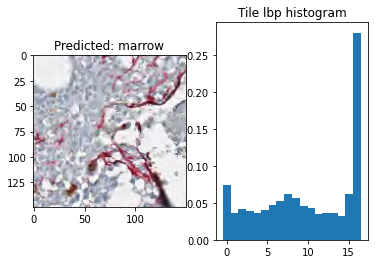

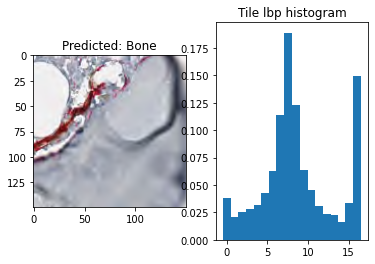

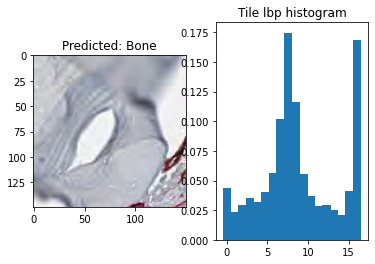

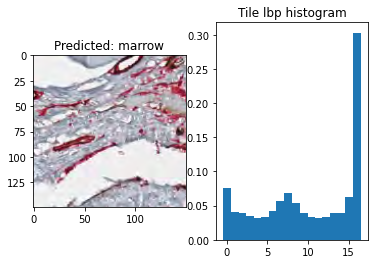

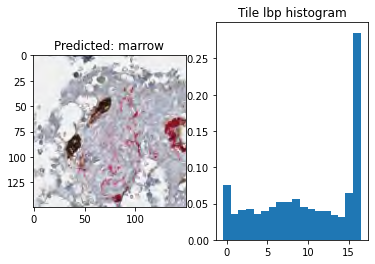

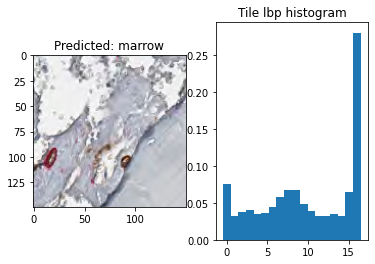

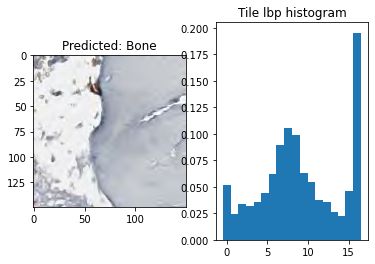

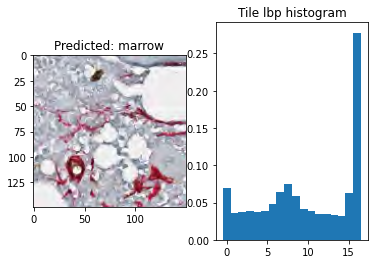

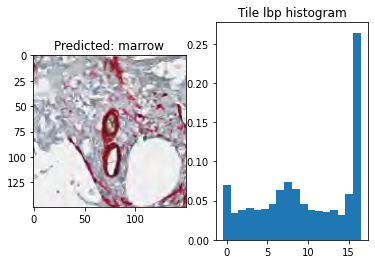

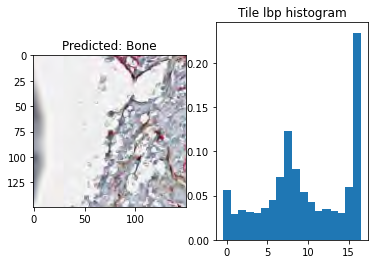

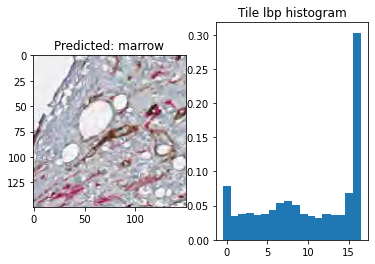

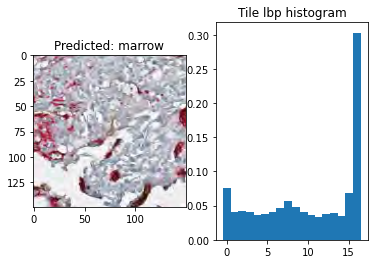

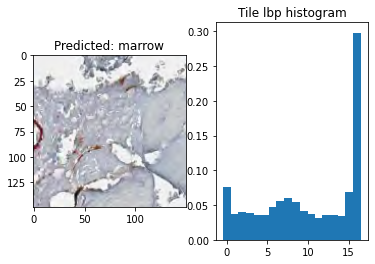

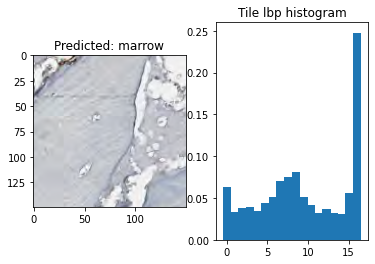

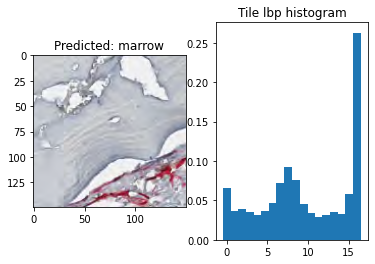

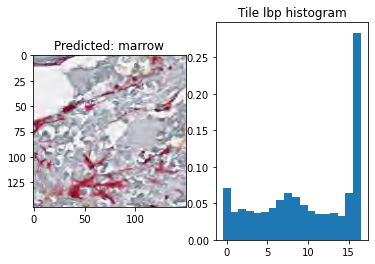

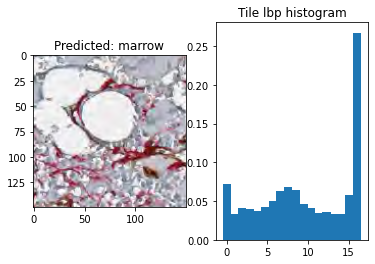

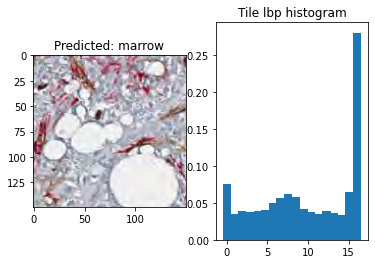

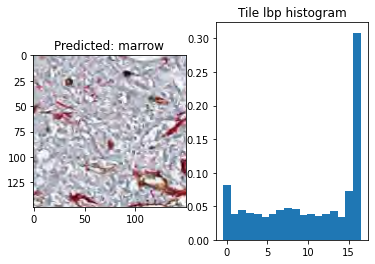

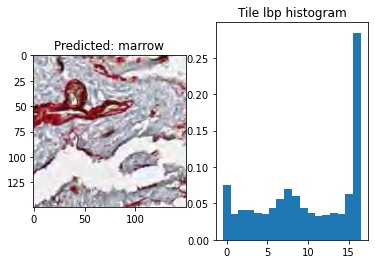

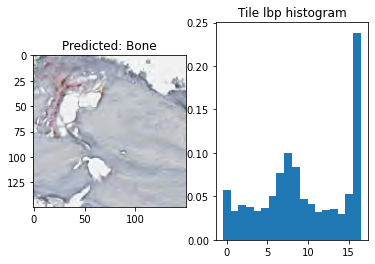

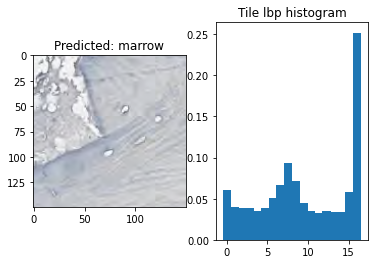

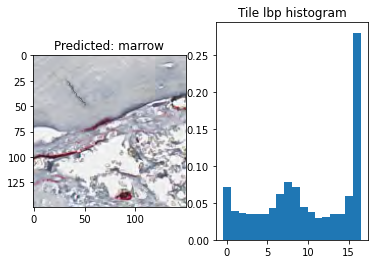

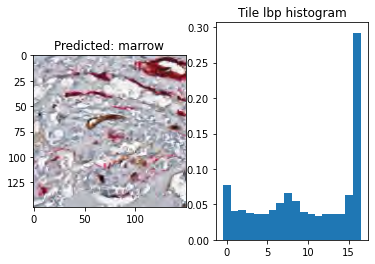

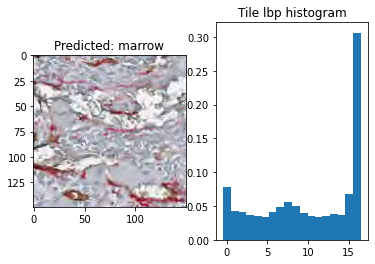

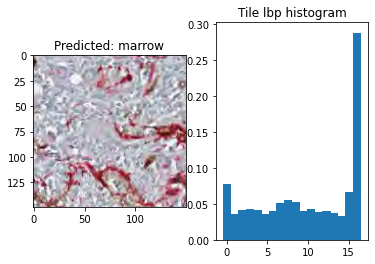

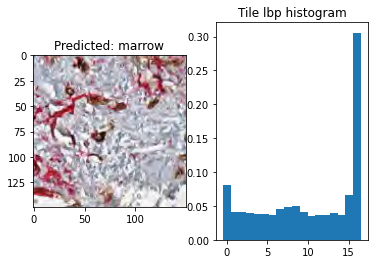

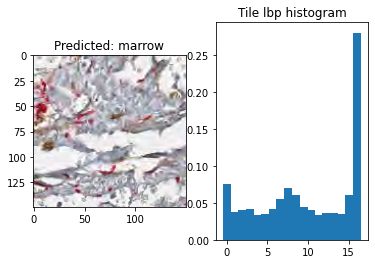

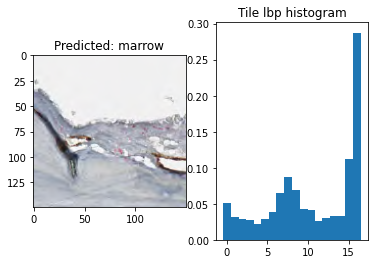

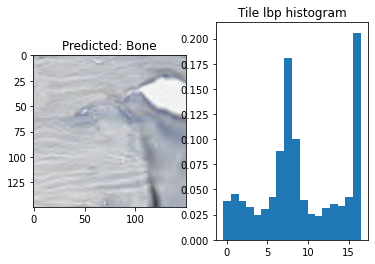

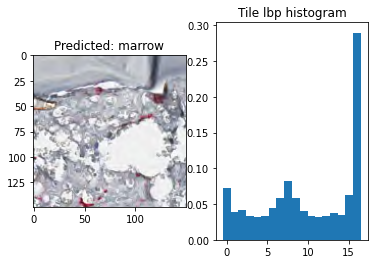

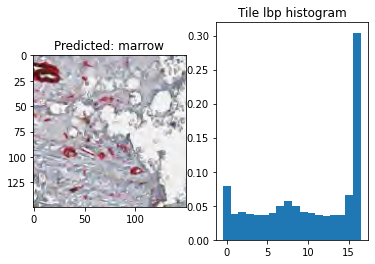

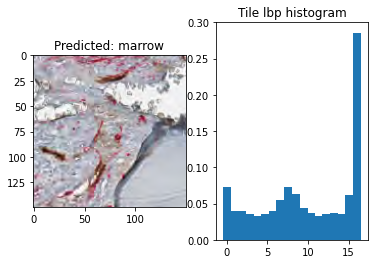

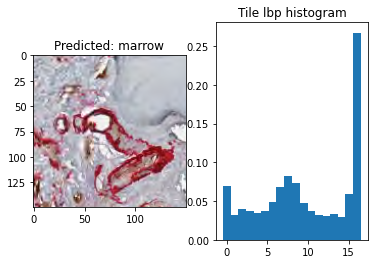

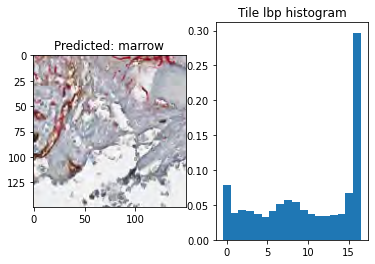

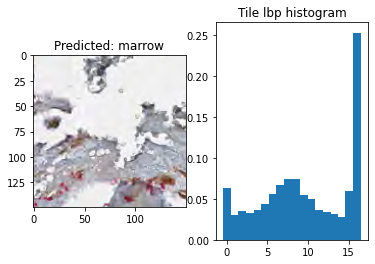

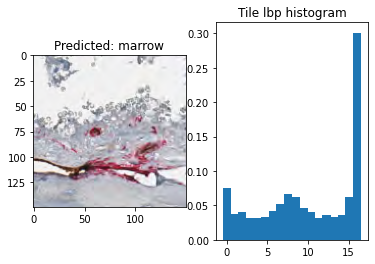

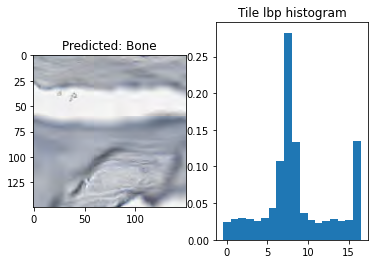

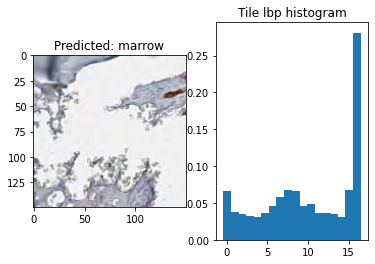

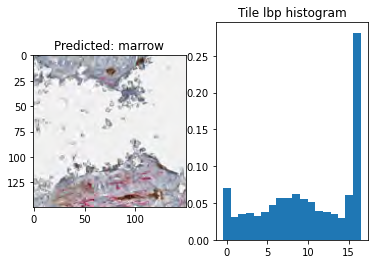

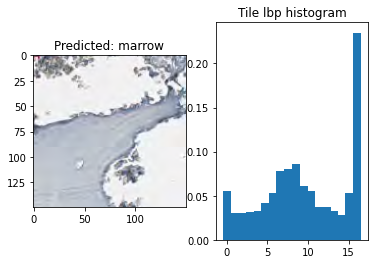

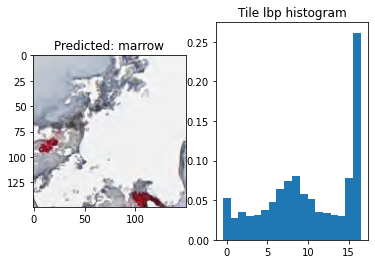

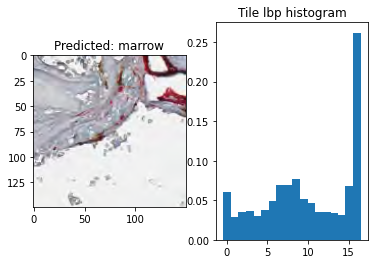

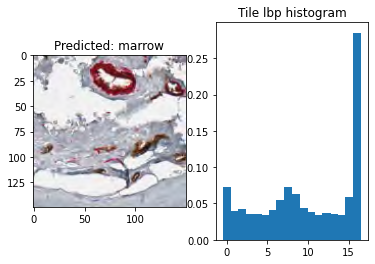

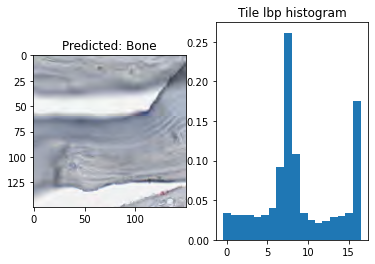

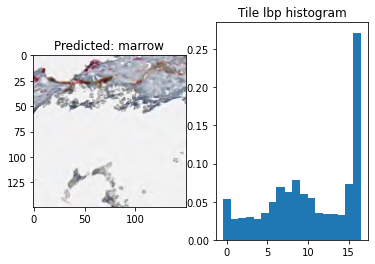

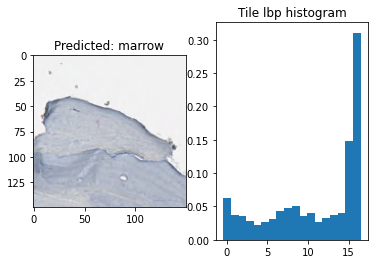

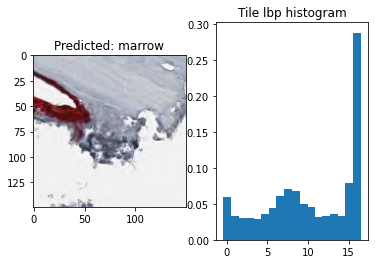

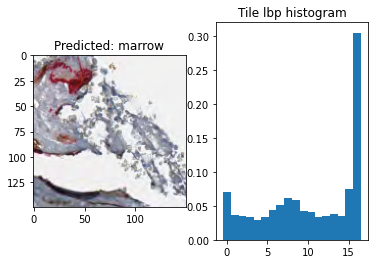

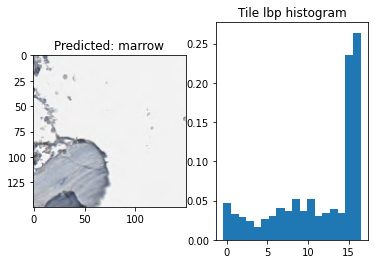

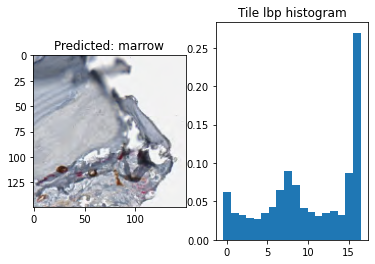

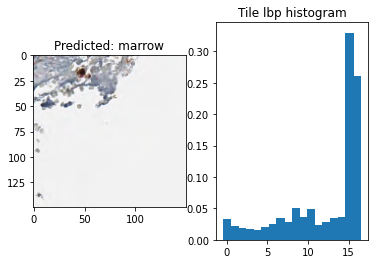

In [6]:
#"testing" comparing lbp histograms to the exemplar histograms
imagepath = r'C:\Users\teole\anaconda3\envs\phy479\bone marrow\images'
images = os.listdir(imagepath)
for im in images:
    impath = os.path.join(imagepath, im)
    image = io.imread(impath, as_gray=True)
    color = io.imread(impath, as_gray=False)
    imlbp = lbp(image, npoints, radius, method='uniform').ravel()
    imhist, _edges = np.histogram(imlbp, bins=int(imlbp.max()+1), density=True)
    score = np.inf
    label = 'No tile type determined.'
    for testlabel in compare.keys():
        newscore = kullback_leibler_divergence(compare[testlabel], imhist)
        if newscore < score:
            score = newscore
            label = testlabel
    
    plt.figure()
    plt.subplot(1,2,1)
    title = f'Predicted: {label}'
    plt.title(title)
    plt.imshow(color)
    plt.subplot(1,2,2)
    plt.title('Tile lbp histogram')
    plt.bar(_edges[:-1], imhist, width=1)
    plt.show()